In [ ]:
# check to make sure we're in the correct env
!conda env list

In [ ]:
# check paths
!echo $HUGGINGFACE_HUB_CACHE
!echo $TRANSFORMERS_CACHE
!echo $HF_HOME
!echo $HOME

In [ ]:
# login to gain access to specific models
from huggingface_hub import login
login()

In [ ]:
# imports
import torch
import transformers
import math
from transformers import AutoTokenizer, AutoModelForCausalLM, DynamicCache, StaticCache
print("Imports completed")

In [ ]:
import json

class HEvictorConfig:
    def __init__(self, input_config):

        # the config list containing tuples of (precision, allocation proportion in percentage)
        # e.g. [(torch.float64, 0.65), (torch.float16, 0.25), (torch.int8, 0.1)] =>
        #    65%, 25%, 10% of cache space dedicated to holding KV pairs in float64, float16, int8 precisions, repspectively
        if type(input_config) == list:
            self.config = input_config

        # if given a file name/path, parse the json file with/at this name/path (e.g. "config.json")
        # json configs should be in the format of:
        # {
        #     "subcaches" : [
        #         {
        #             "precision" : "float64",
        #             "proportion" : 0.65
        #         },
        #         {
        #             "precision" : "float16",
        #             "proportion" : 0.25
        #         },
        #         {
        #             "precision" : "int8",
        #             "proportion" : 0.1
        #         }
        #     ]
        # }
        elif type(input_config) == str:
            self.config = []
            with open(input_config) as json_file:
                json_data = json.load(json_file)

                # parse the json file for config details
                for config_dict in json_data["subcaches"]:
                    dtype = getattr(torch, config_dict["precision"])
                    self.config.append(tuple((dtype, config_dict["proportion"])))

# # Test out the parser/constructor
# he_config = HEvictorConfig("config.json")
# print(he_config.config)

In [ ]:
class HESubCache:
    def __init__(self, precision, max_capacity, parent_he_wrapper, subsequent_sub_caches=[]):
        self.precision = precision # the precision this cache stores its KV-pairs in
        self.dtype_size = get_available_precision_size(self.precision)
        self.max_capacity = max_capacity # this subcache's maximum capacity (in terms of # of KV-pairs)
        self.effective_size = self.max_capacity * self.dtype_size # in bytes; Note: to calculate the total memory consumption of this cache, multiply this with the # of parameters per KV-pair

        self.cached_token_indices = [] # keeps track of the indices this subcache is currently storing
        self.wrapper = parent_he_wrapper # the parent wrapper object that manages the whole HEvictor cache structure

        # an optional list of ordered subsequent subcaches with less precision
        # e.g. in a config of [(torch.float64, 0.65), (torch.float16, 0.25), (torch.int8, 0.1)], the
        # subcache with precision torch.float64 should have subsequent_sub_caches = [SubCache of torch.float16, SubCache of torch.int8]
        self.subsequent_sub_caches = subsequent_sub_caches

    def is_full(self):
        return len(self.cached_token_indices) >= self.max_capacity

    def print_subcache(self): # helper for testing/visualization
        print()
        print("SubCache precision:", self.precision)
        print("Number of cached KV-pairs:", len(self.cached_token_indices))
        # print("Token indices corresponding to the cached KV-pairs:", self.cached_token_indices)
        print("Effective size used:", len(self.cached_token_indices) * self.dtype_size,
              "/", self.max_capacity * self.dtype_size)
        print("Subsequent subcaches' precisions:", [subcache.precision for subcache in self.subsequent_sub_caches])
        print()

    # Insert an incoming token into this subcache; invokes this cache's evict operation if necessary
    def insert(self, token_index):
        if len(self.cached_token_indices) >= self.max_capacity:
            self.evict()

        # update the static cache's KV-pair of the given token to this subcache's precision
        self.wrapper.simulate_update_or_evict(token_index, self.precision)

        self.cached_token_indices.append(token_index)
        assert len(self.cached_token_indices) <= self.max_capacity # make sure that this cache doesn't exceed its capacity
        self.cached_token_indices.sort()

    # Evicts one token's KV-Pair out of this subcache and insert the victim into the next subsequent cache (if it exists)
    def evict(self):
        victim_index = self.wrapper.a2s_find_victim(self.cached_token_indices)
        assert victim_index in self.cached_token_indices # make sure the identified victim is actually stored in this cache

        if len(self.subsequent_sub_caches) == 0: # the base case (if there are no more subsequent subcaches)
            self.wrapper.simulate_update_or_evict(victim_index) # fully evict the victim
        else:
            self.subsequent_sub_caches[0].insert(victim_index) # else, cascade this subcache's victim into the next subsequent subcache

        self.cached_token_indices.remove(victim_index)


In [ ]:
class HEvictorCacheWrapper:
    def __init__(self, underlying_cache, max_effective_size, model_precision, he_config):
        self.underlying_cache = underlying_cache # the underlying HF Cache instance

        # The maximum effective size of this hierarchical cache (in bytes)
        # Note: to calculate the total memory consumption of this cache, multiply this with the # of parameters per KV-pair (which is a constant)
        self.max_effective_size = max_effective_size

        self.model_precision = model_precision # the original precision used by the model
        self.model_dtype_size = get_available_precision_size(self.model_precision)

        self.current_token_index = 0 # keeps track of the current index being processed
        self.evicted_token_indices = [] # keeps track of the indices that are fully evicted

        self.he_config = he_config.config # set the provided HEvictorConfig
        self.he_config.sort(reverse=True, key=lambda sc_config : sc_config[1]) # sort by largest sub cache (percentage)
        self.sub_caches = [] # list of new HESubCache objects

        # ----------1. construct new subcaches according to the he_config------------
        for tup in self.he_config:
            # calculate the max effective size (in bytes) of each sub cache using the specified proportion from the config
            sub_cache_effective_size = math.floor(self.max_effective_size * tup[1])
            if sub_cache_effective_size > 0:
                # calculate how many KV-pairs we can fit into this subcache given its effective size and precision
                sub_cache_max_capacity = sub_cache_effective_size // get_available_precision_size(tup[0])
                sub_cache = HESubCache(tup[0], sub_cache_max_capacity, self)
                self.sub_caches.append(sub_cache)

        # make sure the effective size of all subcaches is less than the specifed max effective size of the entire hierarchical cache
        assert sum([sc.effective_size for sc in self.sub_caches]) <= self.max_effective_size

        # finally, total up the capacity (in # of KV-Pairs) of all subcaches to get the capacity of the entire hierarchical cache
        self.max_capacity = sum([sc.max_capacity for sc in self.sub_caches])
        # ----------------------------------------------------------------------------------


        # ------2. Link together subcaches by populating the 'subsequent subcaches' property of each subcache--------
        # sort subcaches by precision from most to least (and keep them sorted this way)
        self.sub_caches.sort(reverse=True, key=lambda sc : sc.dtype_size)

        # have each subcache's subsequent_sub_caches property contain all subcaches 'following' it (in the above order)
        for i in range(len(self.sub_caches)):
            self.sub_caches[i].subsequent_sub_caches = self.sub_caches[i+1:]
        # -----------------------------------------------------------------------------------------------------------


    # insert a token index's KV-pair into the most-precise cache
    def insert(self, index):
        self.sub_caches[0].insert(index)


    # Find the token with the lowest a2s and return its index
    # candidate_token_indices: the list of token indices to consider evicting
    # output: the index of the token with the lowest a2s
    def a2s_find_victim(self, candidate_token_indices):
        victim_token_index, victim_token_score = 0, float('inf')
        for i in range(self.current_token_index):
            if i not in candidate_token_indices or i in self.evicted_token_indices: # don't check the indices that are fully evicted
                continue

            a2s_value = self.a2s[i]
            if a2s_value < victim_token_score:
                victim_token_index, victim_token_score = i, a2s_value

        assert victim_token_index not in self.evicted_token_indices
        assert victim_token_index in candidate_token_indices

        return victim_token_index


    # Simulates an update or eviction by updating the KV pair corresponding to the token_index in the underlying_cache to either:
    # - all zeros, if no precision is given (which signals a full eviction)
    # - have the new lower precision, if one is given
    # token_index: the index of the token to update or evict
    # precision: a dtype of the new precision to use; default=0 (zero out values/full eviction)
    def simulate_update_or_evict(self, token_index, precision=0):

        # operate on the KV-pairs at the token's index for every layer
        # key_cache and value_cache dimensions: (num_layers, batch_size, num_key_value_heads, max_cache_len, head_dim)
        underlying_cache = self.underlying_cache
        num_layers = len(underlying_cache.key_cache)
        dummy_layer_shape = underlying_cache.key_cache[0].shape # only used to get the shape below
        zeros_shape = (dummy_layer_shape[0], dummy_layer_shape[1], dummy_layer_shape[3]) # (batch_size, num_key_value_heads, head_dim)
        for i in range(num_layers):
            original_key_tensor = underlying_cache.key_cache[i][:, :, token_index, :]
            original_val_tensor = underlying_cache.value_cache[i][:, :, token_index, :]
            updated_key_tensor = torch.zeros(zeros_shape) # default behavior: zero out the tensors (full eviction)
            updated_val_tensor = torch.zeros(zeros_shape)

            # if updating/quantizing, we quantize the token's KV-tensors into the specified precision
            if precision != 0:
                updated_key_tensor = original_key_tensor.to(precision)
                updated_val_tensor = original_val_tensor.to(precision)

            underlying_cache.key_cache[i][:, :, token_index, :] = updated_key_tensor
            underlying_cache.value_cache[i][:, :, token_index, :] = updated_val_tensor

        # update cache info
        if precision == 0:
            self.evicted_token_indices.append(token_index)

    def print_subcache(self): # helper for testing/visualization
        for subcache in self.sub_caches:
            subcache.print_subcache()


In [ ]:
# helper to accumulate attention scores
#
# input:
#     - a2s: the current a2s to add to (max_sequence_length)
#     - new_a2s: a2s from a new decode step to add (max_sequence_length)
#     - forget_factor: inspired by A2SF (https://arxiv.org/pdf/2407.20485), factor to penalize scores of earlier tokens
#        Default = 1 (fully retain all scores of all tokens)
def accumulate_attention_scores(a2s, new_a2s, forget_factor = 1):
    a2s *= forget_factor # this compounds the forget_factor onto scores of existing tokens (before adding the new scores)
    for i in range(len(new_a2s)):
        a2s[i] += new_a2s[i]
    # a2s += new_a2s

torch.set_printoptions(sci_mode=False)

In [ ]:
def run_one_inference_request(prompt, model, tokenizer, he_config, verbose=True, use_wrapper=None):
    with torch.no_grad():
        # inputs: {'input_ids': tensor([[128000,     72,   1053,   1093,    311]], device='cuda:0'),
        #          'attention_mask': tensor([[1, 1, 1, 1, 1]], device='cuda:0')}
        inputs = tokenizer(text=prompt, return_tensors="pt", return_attention_mask=True).to(single_device)
        input_sequence_length = inputs.input_ids.shape[1]
        max_sequence_length = input_sequence_length + max_new_tokens

        # dimensions
        layer_count = model.config.num_hidden_layers
        batch_size = 0 # updated in iteration loop
        num_heads = 0 # updated in iteration loop
        curr_sequence_length = 0 # updated in iteration loop

        # accumulated attention scores: contains the score used to determine which token's KV pair to evict
        # should ultimately sum up to the max_sequence_length (since each token contributes an array that sums up to 100%)
        a2s = torch.zeros((max_sequence_length), dtype=model_dtype).to(single_device) # (max_sequence_length)

        # the underlying cache object used behind the scenes
        underlying_cache = DynamicCache() # use a dynamic cache for better compatability with (legacy) other models;
        # Deprecated: underlying_cache = StaticCache(config=model.config, batch_size=1, max_cache_len=max_sequence_length, device=model.device, dtype=model.dtype)

        # --------------------- Hierarchical KV cache instantiation ----------------------
        # the wrapper cache that simulates evictions;
        # Note: the properties of the underlying_cache (whether it auto-resizes or not) doesn't actually matter since
        # this Wrapper object simulates evictions via manually quantizing/zeroing out KV-pair tensors in the underlying cache
        kv_cache = HEvictorCacheWrapper(underlying_cache, max_effective_size, model_dtype, he_config)
        # --------------------------------------------------------------------------------

        if use_wrapper is not None:
            kv_cache = use_wrapper
            use_wrapper.max_sequence_length = max_sequence_length

        generated_ids = inputs.input_ids # (batch_size, input_sequence_length)
        cache_position = torch.arange(input_sequence_length, dtype=torch.int64).to(single_device) # (input_sequence_length) a list of ints starting from 0

        for i in range(max_new_tokens):
            # model type : output type;
            # llama : LlamaForCausalLM
            # qwen : Qwen2ForCausalLM
            outputs = model(**inputs, cache_position=cache_position, past_key_values=kv_cache.underlying_cache,
                            use_cache=True, output_attentions=True)

            # ---------- 1. accumulate attention scores of this iteration ----------
            # outputs.attentions: (layer_count, batch_size, num_heads, curr_sequence_length, max_sequence_length)
            # e.g. for Llama-3.2-1B: 16, 1, 32, curr_sequence_length, max_sequence_length
            #
            # Sum over all dimensions to get the a2s/token for this iteration
            # Note: curr_sequence_length is always 1 duing decode stages and equal to input_sequence_length during prefill
            sum_over_layers = sum(outputs.attentions) # (batch_size, num_heads, curr_sequence_length, max_sequence_length)
            batch_size = sum_over_layers.shape[0]
            num_heads = sum_over_layers.shape[1]
            curr_sequence_length = sum_over_layers.shape[2]

            a2s_this_iteration = sum_over_layers.sum((0, 1, 2)).to(single_device) # (max_sequence_length or the seq_length so far)

            # Sanity check: the sum of a2s_this_iteration should total up to:
            # layer_count * batch_size * num_heads * curr_sequence_length
            assert abs(sum(a2s_this_iteration) - layer_count * batch_size * num_heads * curr_sequence_length) < 0.001

            # accumulate this iteration's a2s
            accumulate_attention_scores(a2s, a2s_this_iteration, forget_factor)
            # ----------------------------------------------------------------------


            # --------- 2. Prepare for next iteration ------------------------------
            # Greedily sample one next token and add it to generated_ids
            next_token_ids = outputs.logits[:, -1:].argmax(-1)
            generated_ids = torch.cat([generated_ids, next_token_ids], dim=-1)

            # Expand the attention mask for the new token (e.g. attention_mask: [1,1] -> [1,1,1])
            attention_mask = inputs["attention_mask"]
            attention_mask = torch.cat([attention_mask, attention_mask.new_ones((attention_mask.shape[0], 1))], dim=-1)
            inputs = {"input_ids": next_token_ids, "attention_mask": attention_mask}

            # update cache_position:
            # set the new cache_position to be the element no. of the last token processed + 1;
            # e.g. (prefill) [0,1,2,3,4] -> [5], (decode 1) [5] -> [6].
            old_cache_position = cache_position
            cache_position = cache_position[-1:] + 1

            # ----------------------------------------------------------------------


            # -------------- 3. Check up and update the cache ----------------------
            # mimic KV-pair inserts by inserting processed token indices into the H-Evictor Cache
            # when full, the insert process will trigger a cascade evict-insert chain down the sequence of subcaches,
            # lowering the precision of KV-pairs at evicted token indices,
            # until fully evicted (at which point the corresponding KV-pair's parameters are zeroed out)
            kv_cache.a2s = a2s
            kv_cache.current_token_index += curr_sequence_length

            for processed_index in old_cache_position:
                if type(processed_index) != int:
                    processed_index = processed_index.item()
                kv_cache.insert(processed_index)

            # ----------------------------------------------------------------------

            # Some sanity checks to see what the final KV cache entries look like
            # if i == max_new_tokens - 1:
            #     print(kv_cache.underlying_cache.key_cache[2][:, :, 74, :])
            #     print(kv_cache.underlying_cache.key_cache[2][:, :, 56, :])
            #     print(kv_cache.underlying_cache.key_cache[2][:, :, 9, :])
            #     print(kv_cache.underlying_cache.key_cache[2][:, :, 6, :])


        # Sanity check in the case of layer_count = 1: the sum of a2s should total up to:
        # layer_count * batch_size * num_heads * (max_sequence_length - 1)
        if forget_factor == 1:
            assert abs(sum(a2s) - layer_count * batch_size * num_heads * (max_sequence_length - 1)) < 0.001

        output = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

        if verbose:
            print("---------------------------------------------------")
            print("Max token length:", max_sequence_length)
            print("Max effective size of hierarchical cache (in bytes):", max_effective_size)
            kv_cache.print_subcache()
            print("Number of fully evicted KV-pairs:", len(kv_cache.evicted_token_indices))
            # print("Evicted token indices (Sorted):", sorted(kv_cache.evicted_token_indices))
            print()
            # print("Output:")
            # print(output)
            print("---------------------------------------------------")

        return output

In [ ]:
# ------------ Define parameters ---------------

# model parameters
max_new_tokens = 100
forget_factor = 0.3
max_effective_size = 500
model_dtype = torch.float64

# models (and their local directories)
llama = "./models/Llama-3.2-1B-64"
# santacoder = "./models/santacoder"
qwen = "./models/qwenHalfB"
qwen7b = "./models/qwen7b"

# available precisions (set of entries: data type -> number size in bytes)
available_precisions = {
    "torch.float64" : 8,
    "torch.float32" : 4,
    "torch.float16" : 2,
    "torch.int16" : 2,
    "torch.int8" : 1
}
def get_available_precision_size(precision):
    return available_precisions.get(str(precision))

# Hierarchical cache and configuration parameters
full_precision_dir_name = "full_precision_config"
full_quantized_dir_name = "full_quantized_config"
static_quantized_dir_name = "static_quantized_config" # 'retained' config
default_he_dir_name = "default_he_config"

full_precision_config = HEvictorConfig("configs/" + full_precision_dir_name + ".json")
full_quantized_config = HEvictorConfig("configs/" + full_quantized_dir_name + ".json")
static_quantized_config = HEvictorConfig("configs/" + static_quantized_dir_name + ".json")
default_he_config = HEvictorConfig("configs/" + default_he_dir_name + ".json")

# evaluation parameters
num_tasks_to_answer = 164
num_samples_per_task = 1

full_precision_ans_filename = full_precision_dir_name + ".jsonl"
full_quantized_ans_filename = full_quantized_dir_name + ".jsonl"
static_quantized_ans_filename = static_quantized_dir_name + ".jsonl"
default_he_ans_filename = default_he_dir_name + ".jsonl"
inf_cache_ans_filename = "inf_cache.jsonl"

a_sample_answer = "    return ''.join(strings)\n" # an answer to one of the 164 human_eval tasks; use this to see a non-zero score


In [ ]:
# load model related properties
single_device = "cuda:0" # when using large models, comment out everywhere that puts tensors onto single_device
model_to_use = qwen7b
print("begin load model")
model = AutoModelForCausalLM.from_pretrained(model_to_use, low_cpu_mem_usage=True, torch_dtype=model_dtype, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_to_use)
print("end load model")

begin load model
end load model


In [ ]:
# Code to run one sample inference
text_prompt = "Starcraft is a real time"
code_prompt = "def nthFibonacci(n): "
print(run_one_inference_request(text_prompt, model, tokenizer, default_he_config))

In [ ]:
# Displays GPU memory usage information
for i in range(torch.cuda.device_count()):
    device = torch.device(f'cuda:{i}')
    reserved_memory = torch.cuda.memory_reserved(device) / 1024**3
    total_memory = torch.cuda.get_device_properties(i).total_memory / 1024**3
    print(reserved_memory, "out of", total_memory, "GB used")

In [ ]:
# Evaluation code:
# runs open-ai's human_eval benchmark on the model and stores the generated responses in a .jsonl file
# run 'evaluate_functional_correctness {file_name}' in cli to score the responses
from human_eval.data import write_jsonl, read_problems

# avg_prompt_len = sum([len(eval_problems["HumanEval/" + str(i)]["prompt"]) for i in range(len(eval_problems))]) / len(eval_problems)
# avg_sol_len = sum([len(eval_problems["HumanEval/" + str(i)]["canonical_solution"]) for i in range(len(eval_problems))]) / len(eval_problems)

def get_problems_sorted_by_length(problems):
    prefix = "HumanEval/"
    tuples_list = []
    for i in range(len(problems)):
        prompt_length = len(problems[prefix + str(i)]["prompt"])
        tuples_list.append([i, prompt_length]) # a sublist of the question number to its prompt length
    tuples_list.sort(key=lambda sublist : sublist[1])

    for sublist in tuples_list: # append the prefix to convert the id into a problem task_id
        sublist[0] = prefix + str(sublist[0])
    return tuples_list

def generate_answers(problems, model, tokenizer, he_cache_config, ans_json_name,
                     limit=num_tasks_to_answer, num_samples_per_task=num_samples_per_task, problem_filter=[]):
    samples = []
    print("starting write to", ans_json_name)
    for _ in range(num_samples_per_task):
        answered_count = 0
        for task_id in problems:
            if answered_count >= limit or task_id not in problem_filter:
                samples.append(
                    dict(task_id=task_id, completion="return 1 # not tested")
                )
            else:
                generated_answer = run_one_inference_request(problems[task_id]["prompt"], model, tokenizer, he_cache_config)
                if answered_count % 25 == 0:
                    print("# of Generated answers:", answered_count + 1)
                samples.append(
                    dict(task_id=task_id, completion=generated_answer)
                )
                answered_count += 1

        print("Number of answered prompts:", answered_count)

    write_jsonl(ans_json_name, samples)
    print("finished writing to", ans_json_name)

eval_problems = read_problems()
fifty_shortest_problems = [tup[0] for tup in get_problems_sorted_by_length(eval_problems)[:50]]
fifty_longest_problems = [tup[0] for tup in get_problems_sorted_by_length(eval_problems)[len(eval_problems) - 50:]]


In [ ]:
# generate answers with different model and/or cache configurations
# generate_answers(eval_problems, model, tokenizer, full_precision_config, inf_cache_ans_filename)
generate_answers(eval_problems, model, tokenizer, static_quantized_config, static_quantized_ans_filename)
generate_answers(eval_problems, model, tokenizer, default_he_config, default_he_ans_filename)
generate_answers(eval_problems, model, tokenizer, full_precision_config, full_precision_ans_filename)
generate_answers(eval_problems, model, tokenizer, full_quantized_config, full_quantized_ans_filename)

In [ ]:
# Code for running Cache config proportion tests

step_size = 5
new_configs = []
# construct ~20 new configs with 3 subcaches and varying proportions of memory allocated to each subcache
for subcache_1_size in range(step_size + 1):
    for subcache_2_size in range(step_size + 1):
        if subcache_1_size + subcache_2_size <= step_size: # size constraint
            proportion1 = subcache_1_size / step_size
            proportion2 = subcache_2_size / step_size
            proportion3 = 1 - proportion2 - proportion1
            assert proportion1 + proportion2 + proportion3 == 1

            new_configs.append(HEvictorConfig([(torch.float64, proportion1),
                                         (torch.float16, proportion2),
                                         (torch.int8, proportion3)]))

# run eval on all these configs
for config in new_configs:
    config_prop = "_".join([str(abs(round(subcache[1], 1))) for subcache in config.config])
    ans_filename = "prop_" + config_prop + ".jsonl"
    generate_answers(eval_problems, model, tokenizer, config, ans_filename, problem_filter=fifty_longest_problems)

In [ ]:
# Code for getting eviction rate statistics of runs
total_evicted_per_config = []
for config in new_configs:
    cumulated_eviction_rate = 0
    for task_id in reversed(fifty_longest_problems):
        prompt = eval_problems[task_id]["prompt"]
        wrapper = HEvictorCacheWrapper(DynamicCache(), max_effective_size, model_dtype, config)
        run_one_inference_request(prompt, model, tokenizer, config, verbose=False, use_wrapper=wrapper)

        # minor optimization; if the longest request incurred no evictions, skip checking the eviction rate of shorter requests
        if len(wrapper.evicted_token_indices) == 0:
            break

        cumulated_eviction_rate += len(wrapper.evicted_token_indices) / (wrapper.max_sequence_length - 1)

    avg_eviction_rate = cumulated_eviction_rate / len(fifty_shortest_problems)
    print("Config:", config.config)
    print("Average eviction rate:", avg_eviction_rate)
    total_evicted_per_config.append(avg_eviction_rate)

In [ ]:
# Eval results for proportional runs on the 50 shortest prompts:
#
# model parameters:
# model used: qwen0.5b
# max_new_tokens = 100
# forget_factor = 0.3
# max_effective_size = 500
# model_dtype = torch.float64
#
# format of used configs:
# (torch.float64, proportion1), (torch.float16, proportion2), (torch.int8, proportion3)
# proportions used (proportion1_proportion2_proportion3) and accuracies:

accs = [0, 0.06097560975609756, 0.054878048780487805, 0.054878048780487805, 0.04878048780487805, 0.04878048780487805,
     0.024390243902439025, 0.054878048780487805, 0.06097560975609756, 0.04878048780487805, 0.04878048780487805,
     0.03048780487804878, 0.036585365853658534, 0.06097560975609756, 0.054878048780487805,
     0.036585365853658534, 0.042682926829268296, 0.04878048780487805,
     0.03048780487804878, 0.04878048780487805,
     0.06707317073170732]

avg_eviction_rates = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00018691588785046728, 0, 0, 0,
                              0.023546626100612242, 0, 0.012675041330586867, 0.22345799206954262, 0.15477100767560034,
                              0.43426604274162706, 0.6492449464998087]

# acc plot
conversion_ratio = len(eval_problems)/len(fifty_shortest_problems)
vmin = 0
vmax = 25
c_axis = [acc * conversion_ratio * 100 for acc in accs]
c_label = "Accuracy (%)"
title = "Accuracy on Short HumanEval Prompts for \n Varying 3-stage Hierarchical Configurations"

# eviction rate plot
vmin = 0
vmax = 70
c_axis = [rate * 100 for rate in avg_eviction_rates]
c_label = "Average Eviction Rate (%)"
title = "Average Eviction Rate on Short HumanEval Prompts for \n Varying 3-stage Hierarchical Configurations"

In [ ]:
# Eval results for proportional runs on the 50 longest prompts:
#
# model parameters:
# model used: qwen0.5b
# max_new_tokens = 100
# forget_factor = 0.3
# max_effective_size = 500
# model_dtype = torch.float64
#
# format of used configs:
# (torch.float64, proportion1), (torch.float16, proportion2), (torch.int8, proportion3)
# proportions used (proportion1_proportion2_proportion3) and accuracies:

accs = [0, 0.012195121951219513, 0.024390243902439025, 0.024390243902439025, 0.042682926829268296, 0.024390243902439025,
     0.006097560975609756, 0.006097560975609756, 0.012195121951219513, 0.018292682926829267, 0.024390243902439025,
     0, 0.018292682926829267, 0.012195121951219513, 0.006097560975609756,
     0, 0, 0,
     0, 0,
     0]

avg_eviction_rates = [0.0, 0.0016326530612244896, 0.0036734693877551023, 0.009803887120609,
                             0.020032463568748833, 0.11004574272296452, 0.003183673469387755, 0.007397163250458449,
                             0.01762573969859828, 0.09121285945300649, 0.18198922570925313, 0.014817895183422643,
                             0.024845911309049926, 0.162856540372041, 0.3921981849387597, 0.12720336410137037, 0.3505203461917031,
                             0.5241780076377719, 0.4825001688907155, 0.6526846771078625, 0.7846644998068747]

# acc plot
conversion_ratio = len(eval_problems)/len(fifty_longest_problems)
vmin = 0
vmax = 10
c_axis = [acc * conversion_ratio * 100 for acc in accs]
c_label = "Accuracy (%)"
title = "Accuracy on Long HumanEval Prompts for \n Varying 3-stage Hierarchical Configurations"

# eviction rate plot
vmin = 0
vmax = 70
c_axis = [rate * 100 for rate in avg_eviction_rates]
c_label = "Average Eviction Rate (%)"
title = "Average Eviction Rate on Long HumanEval Prompts for \n Varying 3-stage Hierarchical Configurations"

/tmp/ipykernel_2165741/1102415922.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('copper')


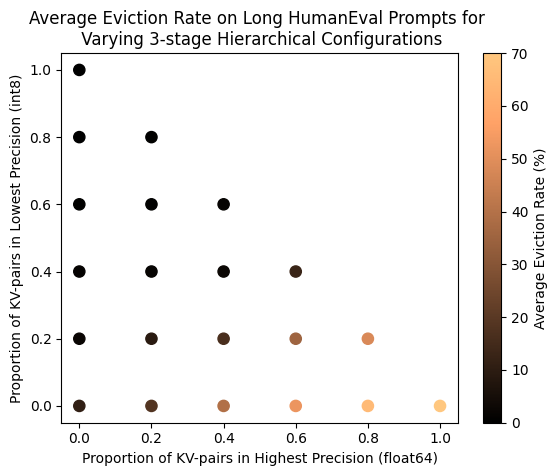

In [ ]:
# Code to generate scatter plot for proportion tests
import matplotlib.pyplot as plt

x = []
y = []
a = []
step_size = 5
for subcache_1_size in range(step_size + 1):
    for subcache_2_size in range(step_size + 1):
        if subcache_1_size + subcache_2_size <= step_size: # size constraint
            proportion1 = subcache_1_size / step_size
            proportion2 = subcache_2_size / step_size
            x.append(proportion1)
            y.append(proportion2)
            a.append(1 - proportion1 - proportion2)

cm = plt.cm.get_cmap('copper')
sc = plt.scatter(x, a, c=c_axis, vmin=vmin, vmax=vmax, s=65, cmap=cm)

plt.colorbar(sc, label=c_label)
plt.xlabel("Proportion of KV-pairs in Highest Precision (float64)")  # subcache[0]
plt.ylabel("Proportion of KV-pairs in Lowest Precision (int8)")  # subcache[-1]
plt.title(title)
plt.show()

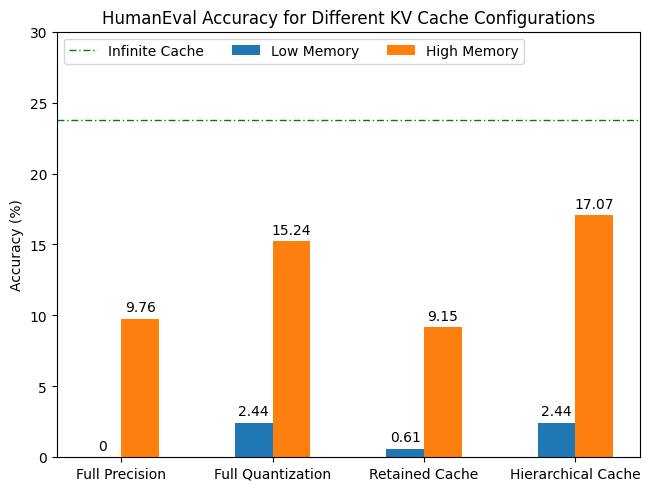

In [ ]:
# Code to generate barchart for config tests on qwen7b

import matplotlib.pyplot as plt
import numpy as np

configs = ("Full Precision", "Full Quantization", "Retained Cache", "Hierarchical Cache")
accuracies = {
    'Low Memory': (0, 0.024390243902439025, 0.006097560975609756, 0.024390243902439025),
    'High Memory': (0.0975609756097561, 0.1524390243902439, 0.09146341463414634, 0.17073170731707318)
}

x = np.arange(len(configs))
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for setting, accs in accuracies.items():
    rounded_accs = [round(acc, 4) * 100 for acc in accs]
    offset = width * multiplier
    rects = ax.bar(x + offset, rounded_accs, width, label=setting)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# add line denoting infinite cache accuracy
inf_cache_acc = 0.23780487804878048
plt.axhline(y=round(inf_cache_acc, 4) * 100, linewidth=1, color='g', dashes=(5, 2, 1, 2), label="Infinite Cache")

# add labels
ax.set_title('HumanEval Accuracy for Different KV Cache Configurations')
ax.set_ylabel('Accuracy (%)')
ax.set_xticks(x + width / 2, configs)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 30)

plt.show()

In [ ]:
#------------------------------Raw Outputs & Data------------------------------------------

In [ ]:
# Set up a chatting scenario

# used model: llama
# max_new_tokens = 60
# forget_factor = 0.3
# max_effective_size = 600
# model_dtype = torch.float64

chat_he_config = HEvictorConfig("configs/chat_he_config.json")

new_prompts = ["Starcraft is a real time", "Tell me more about the three races in the game.", "When was the game released again?"]
prompt_delimiter = ". "
accumulated_prompt_static = ""
accumulated_prompt_he = ""

for i in range(len(new_prompts)):
    # print("New Prompt", i + 1, ":", new_prompts[i])

    # accumulate new prompts
    accumulated_prompt_static += new_prompts[i]
    accumulated_prompt_he += new_prompts[i]

    # print out only the cache details of the final inference
    verbose = i == len(new_prompts) - 1

    accumulated_prompt_static = run_one_inference_request(accumulated_prompt_static,
                                                          model, tokenizer, static_quantized_config, verbose=verbose) + prompt_delimiter
    accumulated_prompt_he = run_one_inference_request(accumulated_prompt_he,
                                                      model, tokenizer, chat_he_config, verbose=verbose) + prompt_delimiter

print("Final accumulated prompt for static cache:", accumulated_prompt_static)
print()
print("Final accumulated prompt for HE cache:", accumulated_prompt_he)

---------------------------------------------------
Max token length: 207
Max effective size of hierarchical cache (in bytes): 600

SubCache precision: torch.float64
Number of cached KV-pairs: 52
Effective size used: 416 / 416
Subsequent subcaches' precisions: [torch.int16]


SubCache precision: torch.int16
Number of cached KV-pairs: 90
Effective size used: 180 / 180
Subsequent subcaches' precisions: []

Number of fully evicted KV-pairs: 64

---------------------------------------------------
---------------------------------------------------
Max token length: 207
Max effective size of hierarchical cache (in bytes): 600

SubCache precision: torch.float64
Number of cached KV-pairs: 45
Effective size used: 360 / 360
Subsequent subcaches' precisions: [torch.float32, torch.float16, torch.int8]


SubCache precision: torch.float32
Number of cached KV-pairs: 30
Effective size used: 120 / 120
Subsequent subcaches' precisions: [torch.float16, torch.int8]


SubCache precision: torch.float16
Num

In [ ]:
# Eval results for qwen7b run with high memory setting:
#
# model parameters:
# model used: qwen7b
# max_new_tokens = 100
# forget_factor = 0.3
# max_effective_size = 500
# model_dtype = torch.float64
#
# H-evictor cache configs used:
# inf_cache, full_precision, full_quant, static_quant, default_he
#
# evaluation parameters:
# num_tasks_to_answer = 164 (all)
# num_samples_per_task = 1
#
# accuracies:
# infinite cache = 0.23780487804878048 (max_effective_size used = 8000000)
# full_precision = 0.0975609756097561
# full_quant = 0.1524390243902439
# static_quant = 0.09146341463414634
# default_he = 0.17073170731707318

In [ ]:
# Eval results for qwen7b run with low memory setting:
#
# model parameters:
# model used: qwen7b
# max_new_tokens = 200
# forget_factor = 0.3
# max_effective_size = 240
# model_dtype = torch.float64
#
# H-evictor cache configs used:
# full_precision, full_quant, static_quant, default_he
#
# evaluation parameters:
# num_tasks_to_answer = 164 (all)
# num_samples_per_task = 1
#
# accuracies:
# full_precision = 0
# full_quant = 0.024390243902439025
# static_quant = 0.006097560975609756
# default_he = 0.024390243902439025

In [ ]:
#--------------------------------Legacy code & outputs----------------------------------------

In [ ]:
# Example output of using a static cache (no quantization)

# Max token length: 57
# Max effective size of hierarchical cache (in bytes): 100

# Cache precision: torch.float64
# Number of cached KV-pairs: 12
# Token indices corresponding to the cached KV-pairs: [0, 37, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
# Effective size used: 96
# Subsequent cache precisions: []

# Evicted token indices (Sorted): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45]

# Output:
# Starcraft is a real time strategy game developed by Blizzard Entertainment. It was released in 1998 for Microsoft Windows and Mac OS X. The game was released on 1987. It was created by and was designed by. Distributed by. Distributed in the US by. Famous



In [ ]:
# Example output of using a hierarchical cache with the same effective size & max token/generation length
# the following configuration is used: HEvictorConfig([(torch.float64, 0.65), (torch.float16, 0.25), (torch.int8, 0.1)])

# Max token length: 57
# Max effective size of hierarchical cache (in bytes): 100

# Cache precision: torch.float64
# Number of cached KV-pairs: 8
# Token indices corresponding to the cached KV-pairs: [0, 47, 48, 49, 52, 53, 54, 55]
# Effective size used: 64
# Subsequent cache precisions: [torch.float16, torch.int8]


# Cache precision: torch.float16
# Number of cached KV-pairs: 12
# Token indices corresponding to the cached KV-pairs: [2, 26, 35, 39, 41, 42, 43, 44, 45, 46, 50, 51]
# Effective size used: 24
# Subsequent cache precisions: [torch.int8]


# Cache precision: torch.int8
# Number of cached KV-pairs: 10
# Token indices corresponding to the cached KV-pairs: [3, 7, 8, 13, 14, 28, 34, 36, 38, 40]
# Effective size used: 10
# Subsequent cache precisions: []

# Evicted token indices (Sorted): [1, 4, 5, 6, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 29, 30, 31, 32, 33, 37]

# Output:
# Starcraft is a real time strategy game developed by Blizzard Entertainment. It was released in 1998 for Windows and Mac OS. The game is set in the science fiction universe of the StarCraft series. The player controls a race of aliens called the Zerg, who are aggressive



In [ ]:
# Old non-hierarchical prototype cache:
class SimulatedCache:
    def __init__(self, static_cache, simulated_max_cache_size, current_size = 0):
        self.static_cache = static_cache # the underlying HF StaticCache instance
        self.current_size = 0 # in terms of # of tokens
        self.max_cache_size = simulated_max_cache_size # in terms of # of tokens

        self.current_token_index = 0 # keeps track of the current index being processed
        self.evicted_token_indices = [] # keeps track of the indices already evicted


    # Finds the token with the lowest a2s and returns its index
    # a2s: the accumulated attention scores used to determine the victim KV-pair to evict
    # output: the token index of the token with the lowest a2s
    def a2s_find_victim(self, a2s):
        victim_token_index, victim_token_score = 0, float('inf')
        for i in range(self.current_token_index):
            if i in self.evicted_token_indices: # don't check the indices that are already evicted
                continue

            a2s_value = a2s[i]
            if a2s_value < victim_token_score:
                victim_token_index, victim_token_score = i, a2s_value

        # make sure the token at this index is not already evicted
        assert victim_token_index not in self.evicted_token_indices
        return victim_token_index


    # Simulates a full eviction of a KV pair from the cache by zeroing out its values in the self.static_cache
    # victim_token_index: the index of the token to evict
    def simulate_full_evict(self, victim_token_index):

        # zero out the KV-pairs at the victim token's index for every layer
        # key_cache and value_cache dimensions: (num_layers, batch_size, num_key_value_heads, max_cache_len, head_dim)
        static_cache = self.static_cache
        num_layers = len(static_cache.key_cache)
        dummy_layer_shape = static_cache.key_cache[0].shape # only used to get the shape below
        zeros_shape = (dummy_layer_shape[0], dummy_layer_shape[1], dummy_layer_shape[3]) # (batch_size, num_key_value_heads, head_dim)
        for i in range(num_layers):
            static_cache.key_cache[i][:, :, victim_token_index, :] = torch.zeros(zeros_shape, device=device);
            static_cache.value_cache[i][:, :, victim_token_index, :] = torch.zeros(zeros_shape, device=device);

        # update cache info
        self.current_size -= 1
        self.evicted_token_indices.append(victim_token_index)


    # If the cache is full, evict a KV-pair with the lowest a2s from the cache.
    # a2s: the accumulated attention score used to determine the victim KV-pair to evict
    def full_evict_maybe(self, a2s):
        if self.current_size < self.max_cache_size:
            return

        # determine the victim to evict (token with the lowest a2s) and simulate the eviction
        victim_token_index = self.a2s_find_victim(a2s)
        self.simulate_full_evict(victim_token_index)

In [ ]:
# code for saving models
import torch
from transformers import pipeline
from transformers import AutoModelForCausalLM

# print("begin load model")
# model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
# model.to(device)
# print("end load model")

model_id = "Qwen/Qwen2.5-Coder-7B-Instruct"

pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.float64,
    device_map="auto"
)
print("end pipe")

# pipe("The key to life is")

pipe.save_pretrained("./models/qwen7b")
print("finished saving")


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

end pipe
finished saving
